<a href="https://colab.research.google.com/github/easleydp/AIAE-to-SPX-total-returns/blob/main/AIAE_to_SPX_total_returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aggregate (or Average) Investor Allocation to Equities (AIAE)

NOTE: Delete the `data` folder to have the CSV files downloaded afresh, otherwise the existing files in that folder will be used.


In [9]:
from pathlib import Path
import urllib.request

# Each  series has values in billions of dollars unless `'millions':true`,
# in which case the values will be transformed from millions to billions.
fred_frames = [
    {'id':"NCBCEL"},
    {'id':"FBCELLQ027S", 'millions':True},
    {'id':"SLGTCMDODNS"},
    {'id':"TCMILBSHNO"},
    {'id':"TCMILBSNNCB"},
    {'id':"FGTCMDODNS"},
    {'id':"WCMITCMFODNS"}
]

data_dir = Path('data')
if not data_dir.exists():
    print('Refreshing CSV files...')
    data_dir.mkdir()
    start_year = 1990  # Min supported is 1952

    for ff in fred_frames:
        id = ff['id']
        url = f'https://fred.stlouisfed.org/graph/fredgraph.csv?cosd={start_year}-01-01&id={id}'
        urllib.request.urlretrieve(url, f'data/{id}.csv')
    print('  CSV files refereshed.')
else:
    print('Using existing CSV files.')



Using existing CSV files.


In [10]:
import pandas as pd
from dateutil.relativedelta import relativedelta

last_fred_frame = None
for ff in fred_frames:
    id = ff['id']
    dataframe = pd.read_csv(f'data/{id}.csv',
        header=0, parse_dates=['DATE'])
    ff['dataframe'] = dataframe

    # The timestamps of the ALFRED data are at the beginning of the quarter to
    # which they correspond, but the values are as of the end of the quarter.
    # Thus, we shift the ALFRED timestamps to the end of the quarter.
    values = dataframe['DATE']
    values.update(values.transform(lambda d: d + relativedelta(months=3)))

    # Convert Value to billions if necessary
    if ff.get('millions', False):
        values = dataframe[ff['id']]
        values.update(values.transform(lambda v: v / 1000))

    # Confirm all dataframes have the same Date series
    if not last_fred_frame is None:
        if not last_fred_frame['dataframe']['DATE'].equals(dataframe['DATE']):
            sys.exit(f'Date series differ between {last_fred_frame["id"]} and {id}!')
    last_fred_frame = ff

# Now we've confirmed all frames have same Date series, transform so that
# Date is used as the index. (This is a preliminary step towards merging.)
for ff in fred_frames:
    dataframe = ff['dataframe']
    dataframe.set_index('DATE', inplace=True, verify_integrity=True)

# Merge the DataFrames into a new one that includes a computed "AIAE" series.
# (We then drop the other series from the new frame.)
def compute_aiae_frame():
    frames = [ff['dataframe'] for ff in fred_frames]
    frame = pd.concat(frames, axis=1)
    # Compute a new "AIAE" series
    frame['AIAE'] = (frame['NCBCEL']+frame['FBCELLQ027S']) / (frame['NCBCEL']+frame['FBCELLQ027S'] + (frame['SLGTCMDODNS']+frame['TCMILBSHNO']+frame['TCMILBSNNCB']+frame['FGTCMDODNS']+frame['WCMITCMFODNS']))
    frame.drop(columns=[ff['id'] for ff in fred_frames], inplace=True)
    return frame
aiae_frame = compute_aiae_frame()
aiae_series = aiae_frame["AIAE"]
last_date = aiae_series.index[-1]
print(f'{aiae_series.size} elements (last one from {last_date.strftime("%Y-%m-%d")})')

125 elements (last one from 2021-04-01)


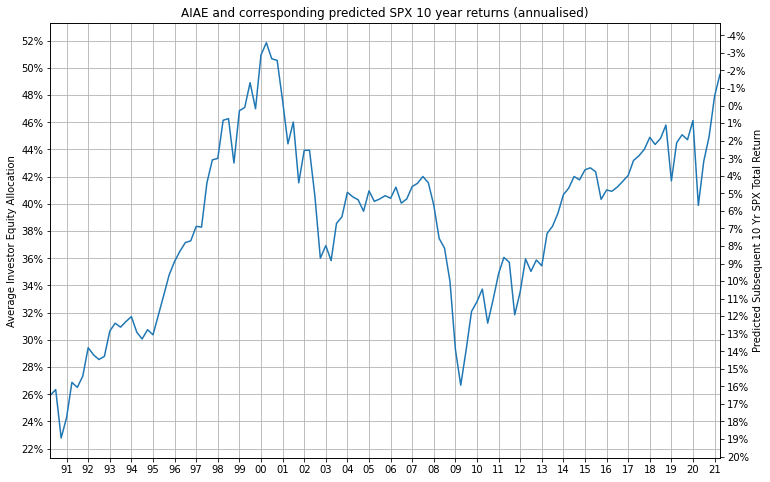

In [11]:
# Plot

%matplotlib inline

def spx_from_aiae(aiae):
    """
    Returns predicted SPX 10 year total return given AIAE percentage (0..1.0)
    """
    # Equation derived from this scatter chart:
    #   https://i2.wp.com/www.philosophicaleconomics.com/wp-content/uploads/2013/12/linearavg1.jpg
    #return 0.335 - 0.678 * aiae

    # Strangely, the AIAE / SPX correlation depicted here is noticably different:
    #   https://i0.wp.com/www.philosophicaleconomics.com/wp-content/uploads/2013/12/avginv11.jpg
    return 0.366 - 0.775 * aiae

# Define a closure function to register as a callback
def update_spx_axis_according_to_aiae_axis(ax_aiae):
    y1, y2 = ax_aiae.get_ylim()
    ax_spx.set_ylim(spx_from_aiae(y1), spx_from_aiae(y2))
    ax_spx.figure.canvas.draw()

fig, ax_aiae = plt.subplots(figsize=(12, 8)) # size in inches
ax_spx = ax_aiae.twinx()

# Automatically update ylim of ax_spx when ylim of ax_aiae changes
ax_aiae.callbacks.connect("ylim_changed", update_spx_axis_according_to_aiae_axis)
ax_aiae.plot(aiae_frame)

# Want x-axis tick for each year
ax_aiae.xaxis.set_major_locator(mdates.YearLocator())
ax_aiae.xaxis.set_major_formatter(mdates.DateFormatter("%y"))

# Don't want any x-axis margin
ax_aiae.margins(x=0)

# Format y-axes as %
ax_aiae.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, 0))
ax_spx.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, 0))

# Control frequency of y-axis ticks (every 2% for AIAE and 1% for SPX)
ax_aiae.yaxis.set_major_locator(mtick.MultipleLocator(0.02))
ax_spx.yaxis.set_major_locator(mtick.MultipleLocator(0.01))

# Want grid lines
ax_aiae.grid()

# Title and y-axis labels
ax_aiae.set_title('AIAE and corresponding predicted SPX 10 year returns (annualised)')
ax_aiae.set_ylabel('Average Investor Equity Allocation')
ax_spx.set_ylabel('Predicted Subsequent 10 Yr SPX Total Return')

# x-axis label rotation <credit: https://stackoverflow.com/a/56139690/65555>
#fig.autofmt_xdate(rotation=45)

plt.show()
